# Adaptive Bayesian Optimization: an optimization of human IED rate 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy
from sklearn.metrics import mean_squared_error
import os.path

## 1. Importing Lou's dataset and calculating IED rate per second

In [2]:
input_path = os.path.abspath('C:/Users/sinad/OneDrive - Georgia Institute of Technology/DrGross/Lou/IED_rate/ied_rate_df.csv')
input_path

'C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\DrGross\\Lou\\IED_rate\\ied_rate_df.csv'

In [3]:
ied_rate_df = pd.read_csv(input_path)
ied_rate_df

,Unnamed: 0,frequency,ied_rate(sec)
0,0,5.5,0.9
1,2,5.5,0.2
2,4,5.5,1.1
3,6,5.5,1.6
4,8,5.5,1.4
...,...,...,...
2797,5790,80.0,0.3
2798,5792,80.0,1.2
2799,5794,80.0,0.2
2800,5796,80.0,0.1


In [4]:
ied_rate_df = ied_rate_df.loc[:,['frequency','ied_rate(sec)']]
ied_rate_df

,frequency,ied_rate(sec)
0,5.5,0.9
1,5.5,0.2
2,5.5,1.1
3,5.5,1.6
4,5.5,1.4
...,...,...
2797,80.0,0.3
2798,80.0,1.2
2799,80.0,0.2
2800,80.0,0.1


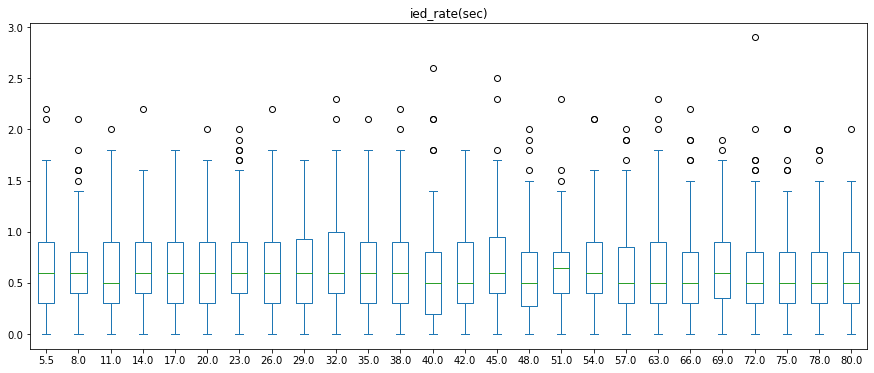

In [ ]:
ied_rate_df.plot.box(by='frequency', figsize=(15, 6));

## 2. Initializing the class and functions for BaO 

In [13]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        ied_rate_df = pd.read_csv(input_path)
        ied_rate_df = ied_rate_df.loc[:,['frequency','ied_rate(sec)']]

        # Get frequency column for input, U1, and IED rate as output, X1
        U1 = ied_rate_df.iloc[:,  0:1]
        X1 = ied_rate_df.iloc[:,  1:2]   

        return U1, X1;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X1, kernel, slice_dim, ylabel):
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
            
        return U1, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        lcb = simY-(np.sqrt(nu*tau_t))*simMse
        
        return lcb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO);
        trained_model_BaO.optimize(messages=False,max_f_eval = 1000);
        
        return trained_model_BaO        
    

## 3. Open Loop BaO

### 3.1: Initialize the model and inputs

In [14]:
model = state_dr_gp()

In [16]:
# Get the input U1 and the X1 outputs
U1, X1 = model.gp_model(input_path)

In [18]:
n_all_samples = np.shape(U1)[0]
n_burn_in = 20
n_acquisition = 100
n_parameters_optimizing = 1 # here we are optimizing freq.  
n_all_parameters = 1 # freq  
n_exp_runs = 30
n_samples_to_remember = 20
print(np.shape(U1.iloc[0:n_all_samples]), np.shape(X1[0:n_all_samples]))
# print(U1)
# print(X1)
n_samples= 150
n_used_samples = 100
print(n_used_samples)

(2802, 1) (2802, 1)
100


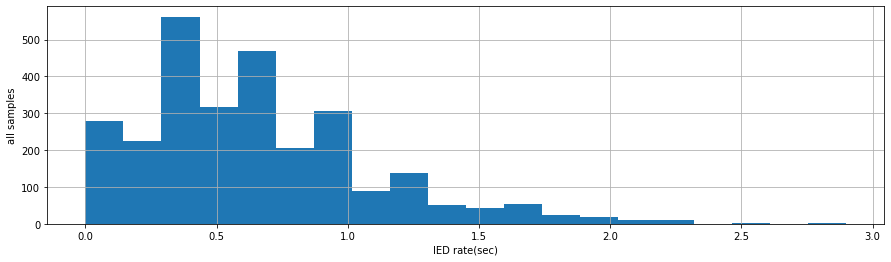

In [21]:
# histogram of raw PSD of preStim gamma
fig = plt.figure(figsize=(15,4));
plt.hist(X1, bins=20);
plt.xlabel("IED rate(sec)")
plt.ylabel("all samples")
plt.grid(visible=True)
#plt.ylabel(f"first {'{0:d}'.format(n_used_samples)} samples")
plt.show();

In [22]:
print(np.shape(U1), np.shape(X1))

(2802, 1) (2802, 1)


### 3.2 First BaO Model is trained on all of the dataset

In [31]:
# ker_RBF = GPy.kern.RBF(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
ker_BaO = GPy.kern.RBF(input_dim=n_all_parameters, variance=0.6, lengthscale=0.4)
print(ker_BaO)

  rbf.         |  value  |  constraints  |  priors
  variance     |    0.6  |      +ve      |        
  lengthscale  |    0.4  |      +ve      |        


In [24]:
slice_dim = 1
ylabel='IED rate'

#### 1.2.1: The first model.

{'dataplot': [<matplotlib.collections.PathCollection at 0x1d98012b6d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d98012bc10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d98012bc40>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    32s40  0004   2.728156e+03   4.562582e+05 
 01m49s74  0014   2.727575e+03   4.565263e+05 
 02m12s02  0017   2.727575e+03   4.565263e+05 
Runtime:  02m12s02
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9801a1370>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9801a18b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9801a18e0>]}

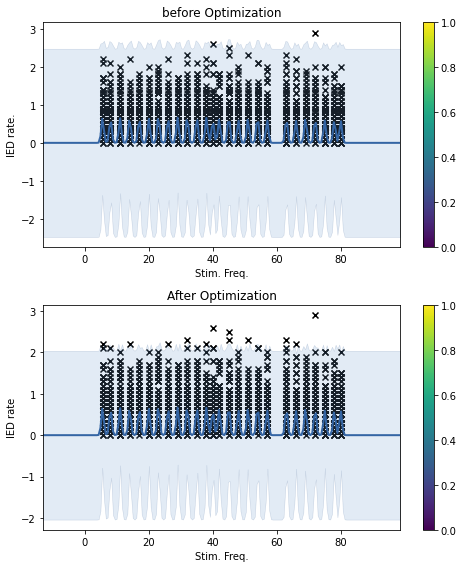

In [28]:
# create simple GP model
trained_model_BaO = GPy.models.GPRegression(U1, X1,ker_BaO)
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO.plot(figure=figure,row=(1),legend=False, xlabel='Stim. Freq.', ylabel='IED rate.',
              title="before Optimization");
display(canvas);
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax);

# optimize and plot
trained_model_BaO.optimize(messages=True,max_f_eval = 100);
canvas_optimized = trained_model_BaO.plot(figure=figure, row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='IED rate', 
                title='After Optimization');
display(canvas_optimized)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
#slices = [1, 50, 100]
#figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

#for i, y in zip(range(3), slices):
#    print((1,y));
#
#    canvas_slices = trained_model_BaO.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
#                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));
#
#display(canvas_slices);

### 3.3: Train the Static model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp 

- The Static model does not use preStimGamma and brain state.
- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [24]:
# applying data mask

U1_X0 = U1.join(X0_psd)

# U1_X0_sel = U1_X0[0:n_used_samples]
# X1_sel = X1[0:n_used_samples]

U1_X0_sel, X1_sel = model.apply_data_mask(U1_X0, X1, n_used_samples)
U1_sel = U1_X0_sel[['Stim_1','Stim_2']]
display(U1_sel)
display(X1_sel.shape)

,Stim_1,Stim_2
1,42,40
2,35,30
3,23,50
4,42,50
5,35,50
...,...,...
95,35,20
96,17,20
97,5,10
98,17,30


(99, 1)

In [25]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1_sel.loc[0:n_burn_in,:]
# X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1_sel[0:n_burn_in,:]
print( '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))


 freq and amplitude used are: 
     Stim_1  Stim_2
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
20      11      40 (20, 2)
sum postStim gamma are: 
 [[28.28259212]
 [35.3155382 ]
 [17.41537359]
 [26.71258011]
 [47.85447968]
 [ 6.13675736]
 [ 3.01429459]
 [28.70903269]
 [30.25154388]
 [36.50382584]
 [40.34110616]
 [ 8.1601432 ]
 [21.91015639]
 [22.44319194]
 [17.26180094]
 [25.97398224]
 [33.03514638]
 [ 1.87336865]
 [18.62013357]
 [33.03904107]] (20, 1)


In [26]:
# input_data
# U1_X0_init = U1_init.join(X0_psd_init)

In [27]:
print(type(U1_init),type(X1_init))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [28]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400.,lengthscale=[10.,80.], ARD=True) + GPy.kern.White(2)
# GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   7.023812e+01   1.774239e+00 
    00s18  0011   6.865959e+01   2.142751e-02 
    00s57  0035   6.854357e+01   6.586212e-14 
Runtime:     00s57
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e6ae2303d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e6b2e3afa0>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e6b2e47970>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e6b2e47eb0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e6b2e57040>]}

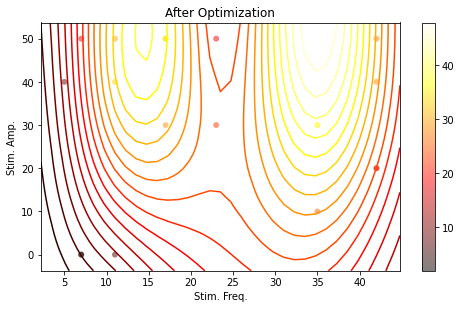

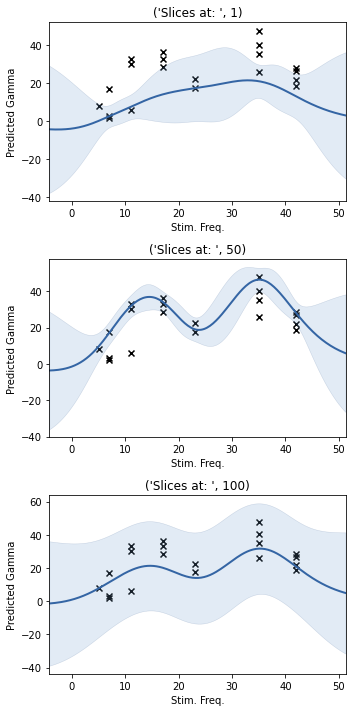

In [29]:
# x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_AF.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_AF.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

In [30]:
print(trained_model_BaO_AF.kern.Mat52.lengthscale.values)
print(trained_model_BaO_AF.kern.Mat52.variance.values[0])

[10.17045148 65.4575036 ]
437.1965362153913


#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [31]:
rand_freq_1d = np.random.choice([5, 7, 11, 17, 23, 29, 35, 42], size=(50))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted, np.shape(rand_freq_1d_sorted))
rand_amp_1d = np.random.choice([10, 20, 30, 40, 50], size=(50))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))
rand_time_1d = np.random.choice(np.arange(0,384),size=(50))
print(rand_time_1d, rand_time_1d.shape)
X_grid_mesh = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted)
X_grid = np.concatenate((np.asarray(X_grid_mesh[0]).reshape(-1,1), np.asarray(X_grid_mesh[1]).reshape(-1,1)),axis = 1)

X_grid_mesh_t = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted, rand_time_1d)
X_grid_t = np.concatenate((np.asarray(X_grid_mesh_t[0]).reshape(-1,1), np.asarray(X_grid_mesh_t[1]).reshape(-1,1), np.asarray(X_grid_mesh_t[2]).reshape(-1,1)),axis = 1)
print(np.shape(X_grid), X_grid_t.shape)

[ 5  5  5  7  7  7  7  7  7  7 11 11 11 11 11 17 17 17 17 17 17 17 17 17
 17 23 23 23 23 23 29 29 29 29 29 29 29 29 35 35 35 35 35 35 35 42 42 42
 42 42] (50,)
[10 10 10 10 10 10 10 10 20 20 20 20 30 30 30 30 30 30 30 30 30 30 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 50 50 50 50 50 50 50 50 50
 50 50] (50,)
[282 220 334  22 203 353 168 102 219 363   3 129  19 116 374   0 176 218
 199 187 257 360  16   4  20 245 190 344 161 368 157 176 357 245 163 211
 216 382 173 181  44  52 312  60 122 108 164 357  58 361] (50,)
(2500, 2) (125000, 3)


In [32]:
# print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

# testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted])
# print(np.shape(testX_BaO))
# testX = np.transpose(testX_BaO)
testX = X_grid
print(np.shape(testX))

(2500, 2)


In [33]:
def static_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, 
                     X1_init, ker_BaO_AF):

    # a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
    ucb = np.empty((1, n_samples))
    ucb_sample = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_static = np.empty((n_acquisition, 1))
    # print(np.shape(ucb))
    model_sample_static = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    static_lengthscale = np.empty((n_parameters_optimizing, n_acquisition))
    static_variance = np.empty((n_acquisition, 1))
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_AF = np.empty((1, n_samples))
        simMse_BaO_AF = np.empty((1, n_samples))
        simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);

        argMax_model = simY_BaO_AF.argmax()
        model_sample_static[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_static_reshaped = np.reshape(model_sample_static[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_static_reshaped)

        ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
        max_ucb = np.max(ucb, axis=0)
        argMax_ucb = ucb.argmax()
        # find the values of argMax_ucb in the sample grid
        ucb_sample[a,:] = np.append(testX[argMax_ucb],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,n_all_parameters))
        # print("Static model prediction: ", ucb_sample_reshaped)

        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation[a] = trained_model_BaO.posterior_samples_f(model_sample_static_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_static[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
        U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_static[a]]
        X1_init = np.append(X1_init, next_postStimGamma, axis=0)

        # trained_model_BaO_AF.add_observer()
        trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF);
        static_lengthscale[:,a] = trained_model_BaO_AF.kern.Mat52.lengthscale.values
        static_variance[a] = trained_model_BaO_AF.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static, static_lengthscale, static_variance

In [34]:
trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static, static_lengthscale, static_variance = static_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)

#### 1.3.3: Plot before and after optimization 

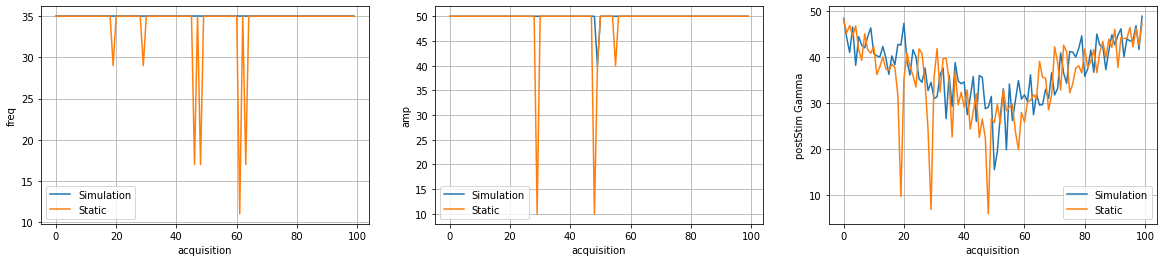

In [35]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_static, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)
plt.show();
# plot the model's max (freq, amp, postStim gamma) at each iteration

In [36]:
np.shape(static_lengthscale)

(2, 100)

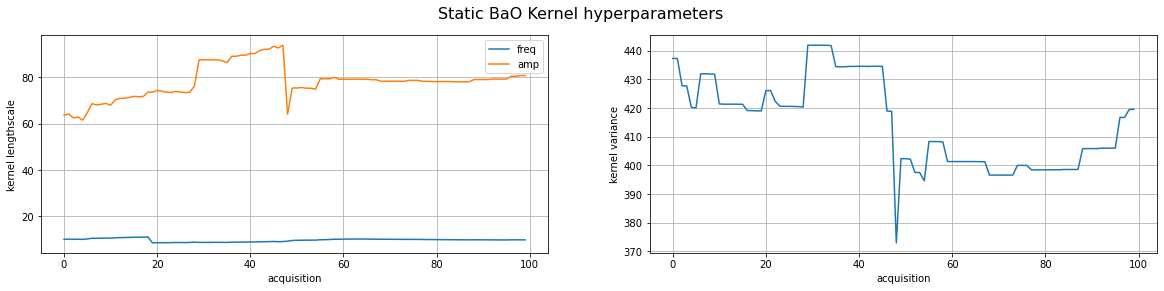

In [37]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Static BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), static_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition),  static_lengthscale[1,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), static_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

In [38]:
# print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])
# print(ucb_sample[1:,2])

[35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 29. 35. 35. 35. 35. 35. 35. 35. 35. 35. 29. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 17. 35. 17. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 11. 35. 17. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35.]
[50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 10. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 10. 40. 50. 50. 50. 50. 50.
 40. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50.]


In [39]:
print(postStimGamma_predicted_from_simulation_static[1:10])

[[45.27202546]
 [46.88575143]
 [44.58480186]
 [46.80195427]
 [41.60862549]
 [39.33309233]
 [45.11387317]
 [41.6484614 ]
 [40.87858221]]


### 1.4: Dynamic BaO

In [55]:
dynamic_model = state_dr_gp()

In [56]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

In [57]:
U1_X0_dynamic = U1_dynamic.join(X0_psd_dynamic)
U1_X0_dynamic_sel, X1_dynamic_sel = dynamic_model.apply_data_mask(U1_X0_dynamic, X1_dynamic, n_used_samples)
U1_dynamic_sel = U1_X0_dynamic_sel[['Stim_1','Stim_2']]
display(U1_dynamic_sel)
display(X1_dynamic_sel.shape)

,Stim_1,Stim_2
1,42,40
2,35,30
3,23,50
4,42,50
5,35,50
...,...,...
95,35,20
96,17,20
97,5,10
98,17,30


(99, 1)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [58]:
U1_init_dynamic = U1_dynamic_sel.loc[0:n_burn_in,:]
X1_init_dynamic = X1_dynamic_sel[0:n_burn_in,:]
# X0_psd_init_dynamic = X0_psd.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
# print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
20      11      40 (20, 2)
sum postStim gamma are: 
 [[28.28259212]
 [35.3155382 ]
 [17.41537359]
 [26.71258011]
 [47.85447968]
 [ 6.13675736]
 [ 3.01429459]
 [28.70903269]
 [30.25154388]
 [36.50382584]
 [40.34110616]
 [ 8.1601432 ]
 [21.91015639]
 [22.44319194]
 [17.26180094]
 [25.97398224]
 [33.03514638]
 [ 1.87336865]
 [18.62013357]
 [33.03904107]] (20, 1)


In [59]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=[10.,80.],ARD=True) + GPy.kern.White(2)
# GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [60]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
# print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)


In [61]:
print(type(U1_init_dynamic),type(X1_init_dynamic))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


#### 1.4.2: Initial training of the Dynamic model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   6.888166e+01   1.296130e-02 
    00s10  0013   6.856235e+01   2.135597e-03 
    00s15  0019   6.855447e+01   1.343792e-05 
    00s27  0035   6.854357e+01   6.586212e-14 
Runtime:     00s27
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e6b35b63a0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e6b35b6730>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e6b3282be0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e6ae5e9100>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e6ae5e90d0>]}

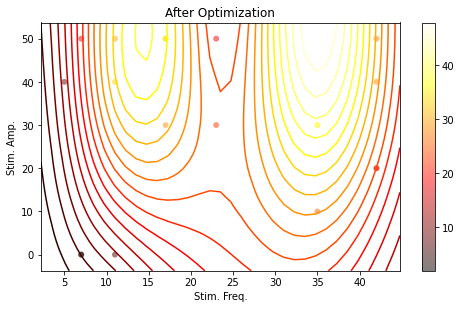

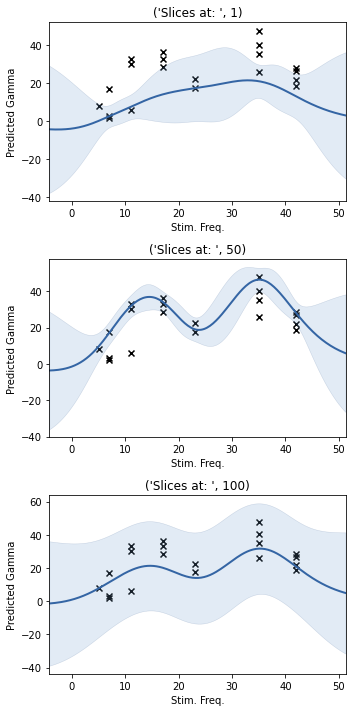

In [62]:
# Initialize a dynamic model:
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
#                                                                                                ker_BaO_dynamic, slice_dim, ylabel)
trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [63]:
print(np.shape(testX))

(2500, 2)


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [64]:
def dynamic_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, 
                     X1_init_dynamic, ker_BaO_dynamic):
    
    ucb_dynamic = np.empty((1, n_samples))
    ucb_sample_dynamic = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_d = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_dynamic = np.empty((n_acquisition, 1))
    # print(np.shape(ucb_dynamic))
    model_sample_dynamic = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    dynamic_lengthscale = np.empty((n_parameters_optimizing, n_acquisition))
    dynamic_variance = np.empty((n_acquisition, 1))    
    
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_dynamic = np.empty((1, n_samples))
        simMse_BaO_dynamic = np.empty((1, n_samples))
        simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX);

        argMax_model = simY_BaO_dynamic.argmax()
        model_sample_dynamic[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_dynamic_reshaped = np.reshape(model_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_dynamic_reshaped)    

        ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
        max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
        argMax_ucb_dynamic = ucb_dynamic.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_dynamic[a, :] = np.append(testX[argMax_ucb_dynamic],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Dynamic model prediction: ", ucb_sample_reshaped)
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_d[a] = trained_model_BaO.posterior_samples_f(model_sample_dynamic_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # print(postStimGamma_predicted_from_simulation_dynamic[a])
        # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
        U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
        U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_samples_to_remember-1),:]

    #     # sum_preStim_gamma
    #     next_preStimGamma_dynamic = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample_dynamic[a,2])]})
    #     X0_psd_init_dynamic = pd.concat([X0_psd_init_dynamic, next_preStimGamma_dynamic], ignore_index=True, axis=0)
    #     X0_psd_init_dynamic_twenty = X0_psd_init_dynamic.loc[a:a+int(n_burn_in),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_dynamic[a]]
        X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
        # print("X1_init_dynamic shape is: ", np.shape(X1_init_dynamic))

        X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_samples_to_remember),:]
        # print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
        # trained_model_BaO_AF.add_observer()
        # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
        trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
        dynamic_lengthscale[:,a] = trained_model_BaO_Dynamic.kern.Mat52.lengthscale.values
        dynamic_variance[a] = trained_model_BaO_Dynamic.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic, dynamic_lengthscale, dynamic_variance

In [65]:
trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic, dynamic_lengthscale, dynamic_variance = dynamic_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


In [66]:
# testX[argMax_ucb_dynamic]
print(np.shape(dynamic_lengthscale))

(2, 100)


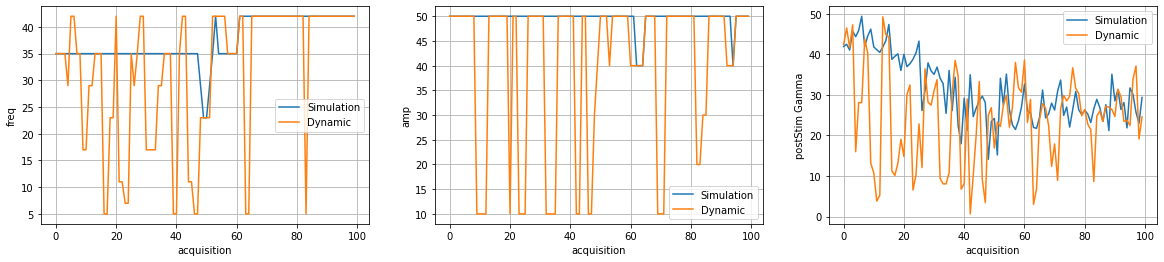

In [67]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[0:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[0:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_d, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_dynamic, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)
plt.show()

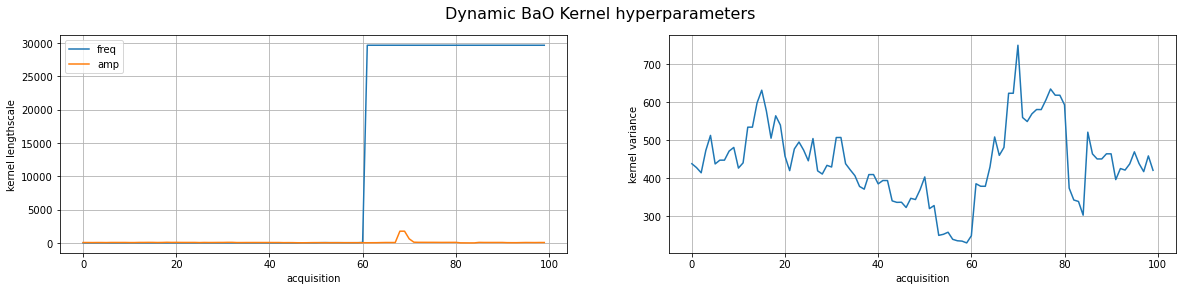

In [68]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Dynamic BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), dynamic_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition),  dynamic_lengthscale[1,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), dynamic_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e6b3278bb0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e6ae526b80>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e6b32f5520>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e6b32f5a60>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e6b32f5a90>]}

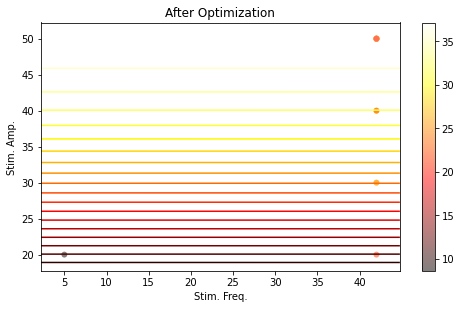

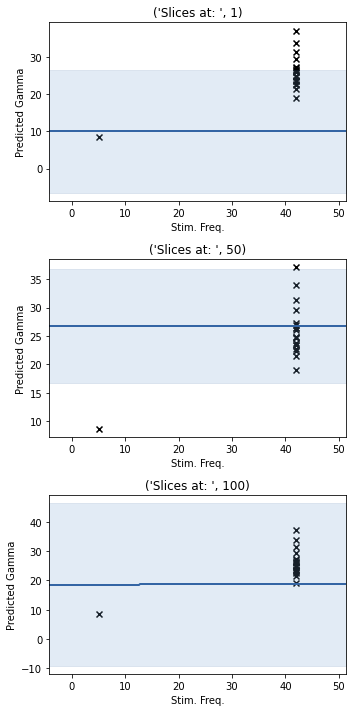

In [69]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: Adaptive BaO

In [70]:
adaptive_model = state_dr_gp()

In [71]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_adaptive, X1_adaptive, lower_bound, upper_bound, X0_psd_adaptive, N_trials = adaptive_model.gp_model(path)

In [72]:
U1_X0_adaptive = U1_adaptive.join(X0_psd_adaptive)
U1_X0_adaptive_sel, X1_adaptive_sel = adaptive_model.apply_data_mask(U1_X0_adaptive, X1_adaptive, n_used_samples)
U1_adaptive_sel = U1_X0_adaptive_sel[['Stim_1','Stim_2']]

In [73]:
time = np.arange(1, n_acquisition)
print(time.shape)
U1_adaptive_sel['time'] = time
print(U1_adaptive_sel.shape)
U1_adaptive_sel

(99,)
(99, 3)


,Stim_1,Stim_2,time
1,42,40,1
2,35,30,2
3,23,50,3
4,42,50,4
5,35,50,5
...,...,...,...
95,35,20,95
96,17,20,96
97,5,10,97
98,17,30,98


In [74]:
U1_init_adaptive = U1_adaptive_sel.loc[0:n_burn_in,:]
X1_init_adaptive = X1_adaptive_sel[0:n_burn_in,:]


In [75]:
print(np.shape(U1_init_adaptive))
print(np.shape(X1_init_adaptive))


(20, 3)
(20, 1)


In [76]:
ker_BaO_adaptive = GPy.kern.Matern52(input_dim=3, variance=400., lengthscale=[10.,80.,500.],ARD=True) + GPy.kern.White(3)

#### 1.5.1: Initial Training of the Adaptive Model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   7.019998e+01   1.675665e+00 
    00s14  0010   6.872984e+01   1.118330e-02 
    00s19  0012   6.861890e+01   1.021926e-02 
    00s29  0036   6.856078e+01   5.914442e-09 
Runtime:     00s29
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e6b36b51f0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e6b36a21f0>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e6b3880d00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e6b38f6cd0>]}

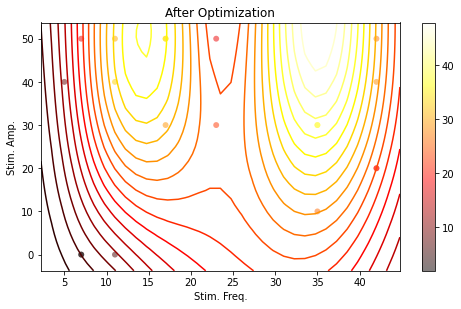

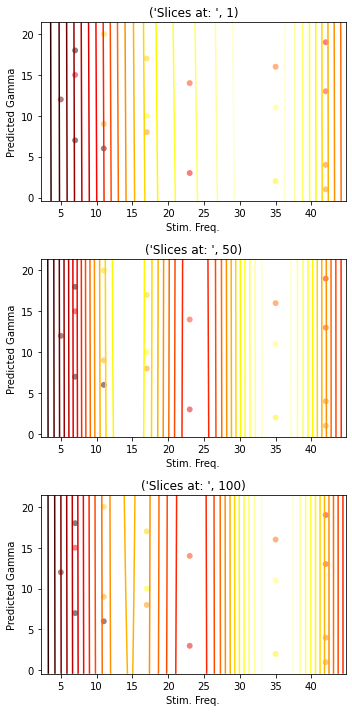

In [77]:
# Initialize the adaptive model:

trained_model_BaO_adaptive = GPy.models.GPRegression(U1_init_adaptive,X1_init_adaptive, ker_BaO_adaptive)
trained_model_BaO_adaptive.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_adaptive.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_adaptive.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

#### 1.5.2: Using the acquisition function to guide the training of the Adaptive model

In [78]:
# making a testX with time
testX_t=X_grid_t
testX_t.shape
print(n_all_parameters)
n_all_parameters_t = 4
print(n_all_parameters_t)
n_parameters_optimizing_t = 3

3
4


In [79]:
def adaptive_BaO_func(n_samples, n_all_parameters, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, 
                     X1_init_adaptive, ker_BaO_adaptive):
    
    ucb_adaptive = np.empty((1, n_samples))
    ucb_sample_adaptive = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_a = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_adaptive = np.empty((n_acquisition, 1))
    model_sample_adaptive = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    adaptive_lengthscale = np.empty((n_parameters_optimizing_t, n_acquisition))
    adaptive_variance = np.empty((n_acquisition, 1))    
    
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_adaptive = np.empty((1, n_samples))
        simMse_BaO_adaptive = np.empty((1, n_samples))
        simY_BaO_adaptive, simMse_BaO_adaptive = trained_model_BaO_adaptive.predict(testX_t);

        argMax_model = simY_BaO_adaptive.argmax()
        model_sample_adaptive[a,:] = np.append(testX_t[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_adaptive_reshaped = np.reshape(model_sample_adaptive[a,:], (1,n_all_parameters))    

        ucb_adaptive = adaptive_model.acquisition_function(simY_BaO_adaptive, simMse_BaO_adaptive, nu, 1)
        max_ucb_adaptive = np.max(ucb_adaptive, axis=0)
        argMax_ucb_adaptive = ucb_adaptive.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_adaptive[a, :] = np.append(testX_t[argMax_ucb_adaptive],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_adaptive[a,:], (1,n_all_parameters))
     
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_a[a] = trained_model_BaO.posterior_samples_f(model_sample_adaptive_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_adaptive[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_adaptive[a,0])], 'Stim_2':[int(ucb_sample_adaptive[a,1])], 'time':[int(ucb_sample_adaptive[a,2])]})
        U1_init_adaptive = pd.concat([U1_init_adaptive, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2','time'], axis=0)
        # U1_init_adaptive_twenty = U1_init_adaptive.loc[a:a+int(n_samples_to_remember-1),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_adaptive[a]]
        X1_init_adaptive = np.append(X1_init_adaptive, next_postStimGamma, axis=0)

        # X1_init_adaptive_twenty = X1_init_adaptive[a:a+int(n_samples_to_remember),:]
        trained_model_BaO_adaptive = adaptive_model.bayes_opt_update_state(U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)
        adaptive_lengthscale[:,a] = trained_model_BaO_adaptive.kern.Mat52.lengthscale.values
        adaptive_variance[a] = trained_model_BaO_adaptive.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_adaptive, model_sample_adaptive, ucb_sample_adaptive, postStimGamma_predicted_from_simulation_a, postStimGamma_predicted_from_simulation_adaptive, adaptive_lengthscale, adaptive_variance

In [80]:
trained_model_BaO_adaptive, model_sample_adaptive, ucb_sample_adaptive, postStimGamma_predicted_from_simulation_a, postStimGamma_predicted_from_simulation_adaptive, adaptive_lengthscale, adaptive_variance = adaptive_BaO_func(
    n_samples, n_all_parameters_t, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)

### 1.6: comparing static and adaptive BaO

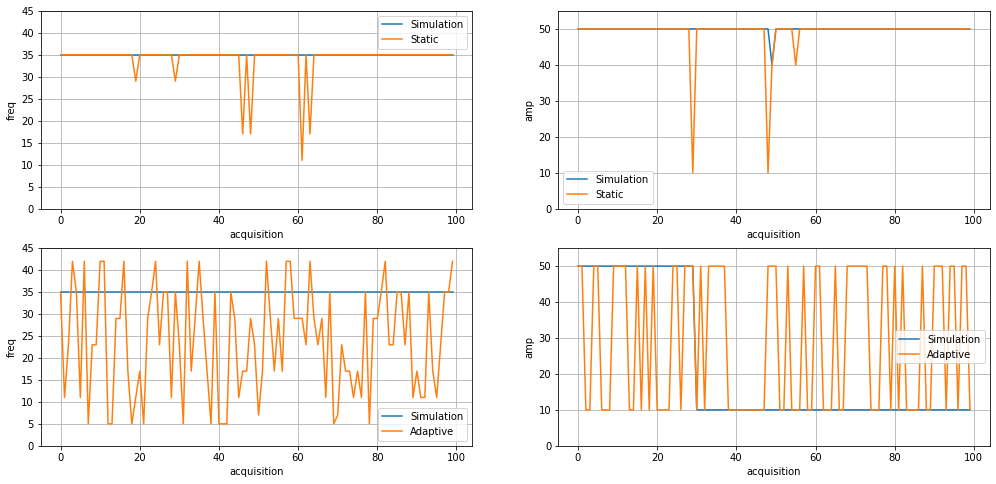

In [81]:
fig = plt.figure(figsize=(17,8));
fig.title = ("Simulation vs. Static/Dynamic BaO")
plt.subplot(2,2,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,3)
plt.plot(np.arange(0,n_acquisition), model_sample_adaptive[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_adaptive[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Adaptive"])
plt.grid(visible=True)

plt.subplot(2,2,4)
plt.plot(np.arange(0,n_acquisition), model_sample_adaptive[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_adaptive[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Adaptive"])
plt.grid(visible=True)

plt.show()


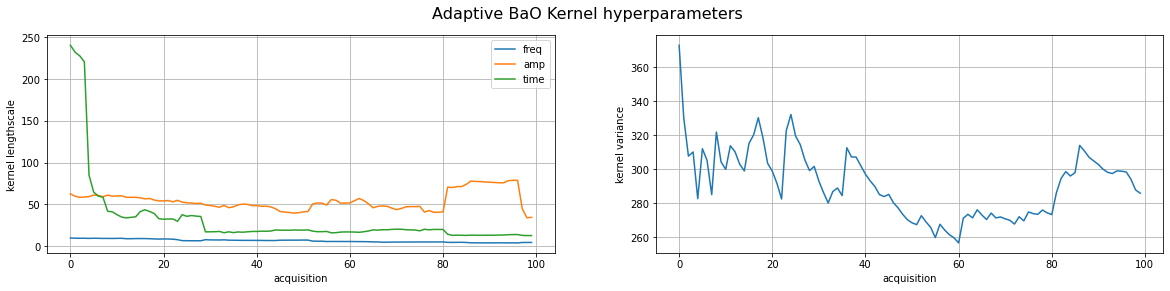

In [82]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Adaptive BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[1,:])
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[2,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp","time"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), adaptive_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

### 1.7: Experiment Loop 

In [83]:
print(np.shape(model_sample_static))

(100, 3)


In [84]:
# Initialize variables:
# reshape variables
static_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
adaptive_sample = np.empty((n_acquisition, n_all_parameters_t, n_exp_runs))
simulation_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
static_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
adaptive_ucb = np.empty((n_acquisition, n_all_parameters_t, n_exp_runs))
simulation_postStimGamma_predicted_d = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
simulation_postStimGamma_predicted_a = np.empty((n_acquisition, 1, n_exp_runs))
adaptive_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_lengthscale = np.empty((n_parameters_optimizing, n_acquisition, n_exp_runs))
static_variance = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_lengthscale = np.empty((n_parameters_optimizing, n_acquisition, n_exp_runs))
dynamic_variance = np.empty((n_acquisition, 1, n_exp_runs))
adaptive_lengthscale = np.empty((n_parameters_optimizing_t, n_acquisition, n_exp_runs))
adaptive_variance = np.empty((n_acquisition, 1, n_exp_runs))

for e in range(0, n_exp_runs): #n_exp_runs
    print('Experiment run: ', e)
    
#     Initial training for satic: trained_model_BaO_AF, ker_BaO_AF
    U1_init = U1_sel.loc[0:n_burn_in,:]
    X1_init = X1_sel[0:n_burn_in,:]
    ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=[10.,80.],ARD=True) + GPy.kern.White(2)
    trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
    trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_dynamic = U1_dynamic_sel.loc[0:n_burn_in,:]
    X1_init_dynamic = X1_dynamic_sel[0:n_burn_in,:]
    ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=[10.,80.],ARD=True) + GPy.kern.White(2)
    trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
    trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_adaptive = U1_adaptive_sel.loc[0:n_burn_in,:]
    X1_init_adaptive = X1_adaptive_sel[0:n_burn_in,:]
    ker_BaO_adaptive = GPy.kern.Matern52(input_dim=n_parameters_optimizing_t, variance=400., lengthscale=[10.,80.,500.],ARD=True) + GPy.kern.White(3)
    trained_model_BaO_adaptive = GPy.models.GPRegression(U1_init_adaptive,X1_init_adaptive, ker_BaO_adaptive)
    trained_model_BaO_adaptive.optimize(messages=True,max_f_eval = 1000);
    
    _, static_sample[:,:,e], static_ucb[:,:,e], simulation_postStimGamma_predicted[:,:,e], static_postStimGamma_predicted[:,:,e], static_lengthscale[:,:,e], static_variance[:,0:1,e] = static_BaO_func(
        n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)
    
    _, dynamic_sample[:,:,e], dynamic_ucb[:,:,e], simulation_postStimGamma_predicted_d[:,:,e], dynamic_postStimGamma_predicted[:,:,e], dynamic_lengthscale[:,:,e], dynamic_variance[:,0:1,e]  = dynamic_BaO_func(
        n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)
    
    _, adaptive_sample[:,:,e], adaptive_ucb[:,:,e], simulation_postStimGamma_predicted_a[:,:,e], adaptive_postStimGamma_predicted[:,:,e], adaptive_lengthscale[:,:,e], adaptive_variance[:,0:1,e]  = adaptive_BaO_func(
        n_samples, n_all_parameters_t, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)
        
    print('end of run. \n ----------------------------------------')

Experiment run:  0
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s13  0013   6.856235e+01   2.135597e-03 
    00s19  0021   6.855396e+01   1.400898e-04 
    00s32  0035   6.854357e+01   6.586212e-14 
Runtime:     00s32
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0009   6.878297e+01   5.606850e-03 
    00s19  0013   6.856235e+01   2.135597e-03 
    00s34  0035   6.854357e+01   6.586212e-14 
Runtime:     00s34
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0003   6.935369e+01   3.679006e-01 
    00s09  0005   6.888391e+01   1.174590e-02 
    00s19  0010   6.872984e+01   1.118330e-02 
    00s47  0036   6.856078e+01   5.914442e-09 
Runtime:     00s47
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


end of run. 
 ----------------------------------------
Experiment run:  1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   7.023812e+01   1.774239e+00 
    00s02  0005   6.888166e+01   1.296130e-02 
    00s05  0013   6.856235e+01   2.135597e-03 
    00s10  0027   6.854468e+01   3.284573e-04 
    00s11  0030   6.854358e+01   1.291708e-07 
    00s13  0035   6.854357e+01   6.586212e-14 
Runtime:     00s13
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   7.221956e+01   7.781209e+00 
    00s02  0004   6.901178e+01   7.908136e-02 
    00s03  0007   6.883055e+01   1.017261e-03 
    00s06  0014   6.855526e+01   2.186626e-04 
    00s14  0028   6.854371e+01   3.251277e-05 
    00s16  0032   6.854357e+01   2.253991e-07 
    00s18  0035   6.854357e+01   6.586212e-14 
Runtime:     00s18
Optimization status: Converged

Running L-BFGS-B (Scipy imple

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


end of run. 
 ----------------------------------------
Experiment run:  2
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0006   6.884338e+01   1.871197e-03 
    00s04  0013   6.856235e+01   2.135597e-03 
    00s06  0019   6.855447e+01   1.343792e-05 
    00s11  0031   6.854358e+01   1.183671e-07 
    00s12  0035   6.854357e+01   6.586212e-14 
Runtime:     00s12
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   6.937377e+01   3.967822e-01 
    00s02  0006   6.884338e+01   1.871197e-03 
    00s07  0016   6.855456e+01   4.393550e-07 
    00s17  0032   6.854357e+01   2.253991e-07 
    00s18  0034   6.854357e+01   6.586212e-14 
    00s19  0035   6.854357e+01   6.586212e-14 
Runtime:     00s19
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   7.019998e+01 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:581: RuntimeWarning:invalid value encountered in multiply


end of run. 
 ----------------------------------------
Experiment run:  7
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   7.221956e+01   7.781209e+00 
    00s02  0005   6.888166e+01   1.296130e-02 
    00s06  0015   6.855457e+01   3.015503e-06 
    00s11  0032   6.854357e+01   2.253991e-07 
    00s12  0035   6.854357e+01   6.586212e-14 
Runtime:     00s12
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   7.221956e+01           nan 
    00s02  0005   6.888166e+01   1.296130e-02 
    00s04  0013   6.856235e+01   2.135597e-03 
    00s07  0019   6.855447e+01   1.343792e-05 
    00s13  0031   6.854358e+01   1.183671e-07 
    00s17  0035   6.854357e+01   6.586212e-14 
Runtime:     00s17
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0004   6.900742e+01  

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


end of run. 
 ----------------------------------------
Experiment run:  8
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0008   6.881616e+01   2.032247e-03 
    00s05  0013   6.856235e+01   2.135597e-03 
    00s09  0027   6.854468e+01   3.284573e-04 
    00s11  0032   6.854357e+01   2.253991e-07 
    00s12  0035   6.854357e+01   6.586212e-14 
Runtime:     00s12
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   6.901178e+01   7.908136e-02 
    00s03  0007   6.883055e+01   1.017261e-03 
    00s06  0014   6.855526e+01   2.186626e-04 
    00s14  0028   6.854371e+01   3.251277e-05 
    00s18  0035   6.854357e+01   6.586212e-14 
Runtime:     00s18
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   6.900742e+01   7.295284e-02 
    00s05  0007   6.883626e+01 

##### 1.7.1: plots for Std Dev and Mean

In [85]:
static_variance.shape
adaptive_lengthscale.shape

(3, 100, 30)

In [86]:
# calculate mean and std dev for the experiment runs
static_sample_mean = np.mean(static_sample,axis=2)
print(np.shape(static_sample_mean),'\n', static_sample_mean[0:3,:])
dynamic_sample_mean = np.mean(dynamic_sample, axis=2)
adaptive_sample_mean = np.mean(adaptive_sample, axis=2)

static_ucb_mean = np.mean(static_ucb, axis=2)
print(np.shape(static_ucb_mean),'\n', static_ucb_mean[0:3,:])
dynamic_ucb_mean = np.mean(dynamic_ucb, axis=2)
adaptive_ucb_mean = np.mean(dynamic_ucb, axis=2)

static_sample_std = np.std(static_sample, axis=2)
print(np.shape(static_sample_std),'\n', static_sample_std[0:3,:])
dynamic_sample_std = np.std(dynamic_sample, axis=2)
adaptive_sample_std = np.std(adaptive_sample, axis=2)

static_ucb_std = np.std(static_ucb, axis=2)
dynamic_ucb_std = np.std(dynamic_ucb, axis=2)
adaptive_ucb_std = np.std(dynamic_ucb, axis=2)

static_lengthscale_mean = np.mean(static_lengthscale, axis=2)
print(np.shape(static_lengthscale_mean),'\n', static_lengthscale_mean[0:3,0:3])
dynamic_lengthscale_mean = np.mean(dynamic_lengthscale, axis=2)
adaptive_lengthscale_mean = np.mean(adaptive_lengthscale, axis=2)

static_variance_mean = np.mean(static_variance, axis=2)
print(np.shape(static_variance_mean),'\n', static_variance_mean[0:3,0:3])
dynamic_variance_mean = np.mean(dynamic_variance, axis=2)
adaptive_variance_mean = np.mean(adaptive_variance, axis=2)

static_lengthscale_std = np.std(static_lengthscale, axis=2)
print(np.shape(static_lengthscale_std),'\n', static_lengthscale_std[0:3,0:3])
dynamic_lengthscale_std = np.std(dynamic_lengthscale, axis=2)
adaptive_lengthscale_std = np.std(adaptive_lengthscale, axis=2)

static_variance_std = np.std(static_variance, axis=2)
print(np.shape(static_variance_std),'\n', static_variance_std[0:3,0:3])
dynamic_variance_std = np.std(dynamic_variance, axis=2)
adaptive_variance_std = np.std(adaptive_variance, axis=2)

(100, 3) 
 [[35.         50.          0.81379952]
 [35.         50.          0.91260986]
 [35.         50.          1.0114202 ]]
(100, 3) 
 [[35.         50.          0.81379952]
 [33.8        50.          0.91260986]
 [34.6        50.          1.0114202 ]]
(100, 3) 
 [[0.00000000e+00 0.00000000e+00 1.11022302e-16]
 [0.00000000e+00 0.00000000e+00 1.11022302e-16]
 [0.00000000e+00 0.00000000e+00 4.44089210e-16]]
(2, 100) 
 [[10.15945141  9.96885488  9.89929895]
 [64.91094784 65.27855049 65.83382921]]
(100, 1) 
 [[433.25450449]
 [428.08143407]
 [428.44742202]]
(2, 100) 
 [[0.16897311 0.72906191 0.83014444]
 [1.08262255 1.81339519 2.33839395]]
(100, 1) 
 [[ 9.71975954]
 [ 9.77975747]
 [12.38560143]]


In [87]:
# Std Dev bar plots:
std_dev_ucb_df = pd.DataFrame({"Freq. (S)": static_ucb_std[:,0],
                               "Amp. (S)": static_ucb_std[:,1],
                                "Freq. (D)": dynamic_ucb_std[:,0],
                                "Amp. (D)": dynamic_ucb_std[:,1],
                                "Freq. (A)": adaptive_ucb_std[:,0],
                                "Amp. (A)": adaptive_ucb_std[:,1]})
display(std_dev_ucb_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,2.400000,0.0,0.000000,0.000000,0.000000,0.000000
2,1.496663,0.0,2.993326,0.000000,2.993326,0.000000
3,1.496663,0.0,2.236068,0.000000,2.236068,0.000000
4,1.496663,0.0,2.749545,16.918103,2.749545,16.918103


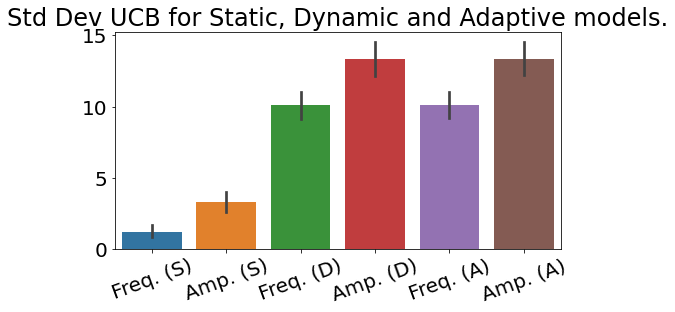

In [88]:
fig = plt.figure(figsize=(8,4));
plt.rc('font', size=20)
sns.barplot(data=std_dev_ucb_df); 
plt.title("Std Dev UCB for Static, Dynamic and Adaptive models.");
plt.xticks(rotation=20)
plt.show();


In [89]:
std_dev_sim_df = pd.DataFrame({"Sim. Freq. (S)": static_sample_std[:,0],
                               "Sim. Amp. (S)": static_sample_std[:,1],
                               "Simu. Freq. (D)": dynamic_sample_std[:,0],
                               "Sim. Amp. (D)": dynamic_sample_std[:,1],
                               "Simu. Freq. (A)": adaptive_sample_std[:,0],
                               "Sim. Amp. (A)": adaptive_sample_std[:,1]})
display(std_dev_sim_df.head())

,Sim. Freq. (S),Sim. Amp. (S),Simu. Freq. (D),Sim. Amp. (D),Simu. Freq. (A),Sim. Amp. (A)
0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,5.026154,0.0
3,0.0,0.0,0.0,0.0,5.026154,0.0
4,0.0,0.0,0.0,0.0,5.385165,0.0


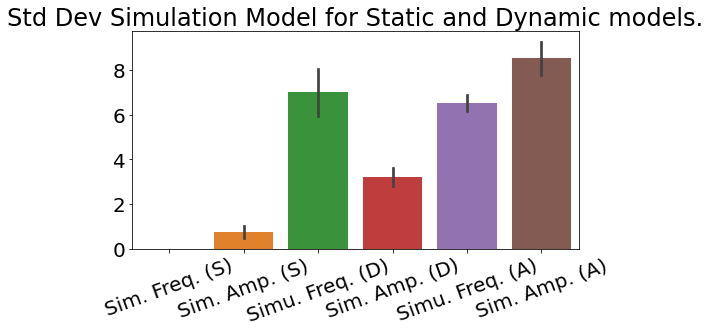

In [90]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_sim_df); 
plt.title("Std Dev Simulation Model for Static and Dynamic models.");
plt.xticks(rotation=20)
plt.show();

In [91]:
# Mean UCB:
mean_ucb_df = pd.DataFrame({"Freq. (S)": static_ucb_mean[:,0],
                            "Amp. (S)": static_ucb_mean[:,1],
                            "Freq. (D)": dynamic_ucb_mean[:,0],
                            "Amp. (D)": dynamic_ucb_mean[:,1],
                            "Freq. (A)": adaptive_ucb_mean[:,0],
                            "Amp. (A)": adaptive_ucb_mean[:,1]})
display(mean_ucb_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,35.0,50.0,35.0,50.000000,35.0,50.000000
1,33.8,50.0,35.0,50.000000,35.0,50.000000
2,34.6,50.0,31.8,50.000000,31.8,50.000000
3,34.6,50.0,34.0,50.000000,34.0,50.000000
4,34.6,50.0,30.8,40.666667,30.8,40.666667


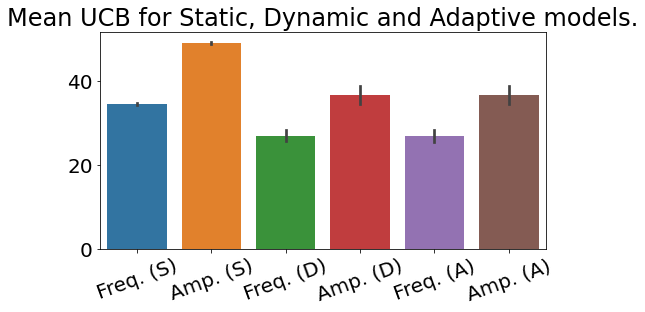

In [92]:
fig = plt.figure(figsize=(8,4));
plt.rc('font', size=20)
sns.barplot(data=mean_ucb_df); 
plt.title("Mean UCB for Static, Dynamic and Adaptive models.");
plt.xticks(rotation=20)
plt.show();

In [93]:
# Mean Simulatino Model:
mean_sim_df = pd.DataFrame({"Freq. (S)": static_sample_mean[:,0],
                            "Amp. (S)": static_sample_mean[:,1],
                            "Freq. (D)": dynamic_sample_mean[:,0],
                            "Amp. (D)": dynamic_sample_mean[:,1],
                            "Freq. (A)": adaptive_sample_mean[:,0],
                            "Amp. (A)": adaptive_sample_mean[:,1]})
display(mean_sim_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,35.0,50.0,35.0,50.0,35.000000,50.0
1,35.0,50.0,35.0,50.0,35.000000,50.0
2,35.0,50.0,35.0,50.0,34.066667,50.0
3,35.0,50.0,35.0,50.0,34.066667,50.0
4,35.0,50.0,35.0,50.0,34.000000,50.0


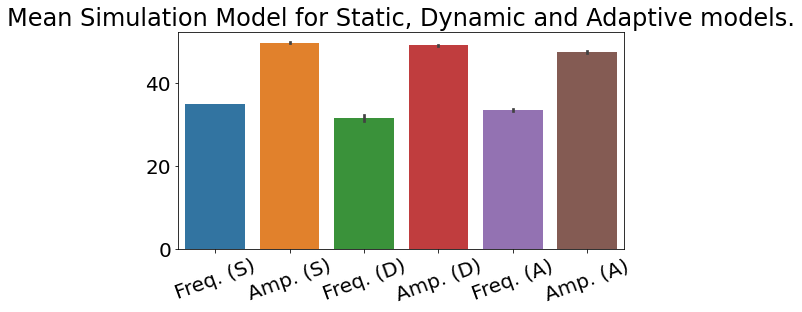

In [94]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_sim_df); 
plt.title("Mean Simulation Model for Static, Dynamic and Adaptive models.");
plt.xticks(rotation=20)
plt.show();

##### 1.7.2: Acquisition plots

 C:\Users\sinad\AppData\Local\Temp\ipykernel_28528\796574978.py:18: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000001E6B3355160> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_28528\796574978.py:18: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000001E6B33555E0> has a label of '_Hidden' which cannot be automatically added to the legend.


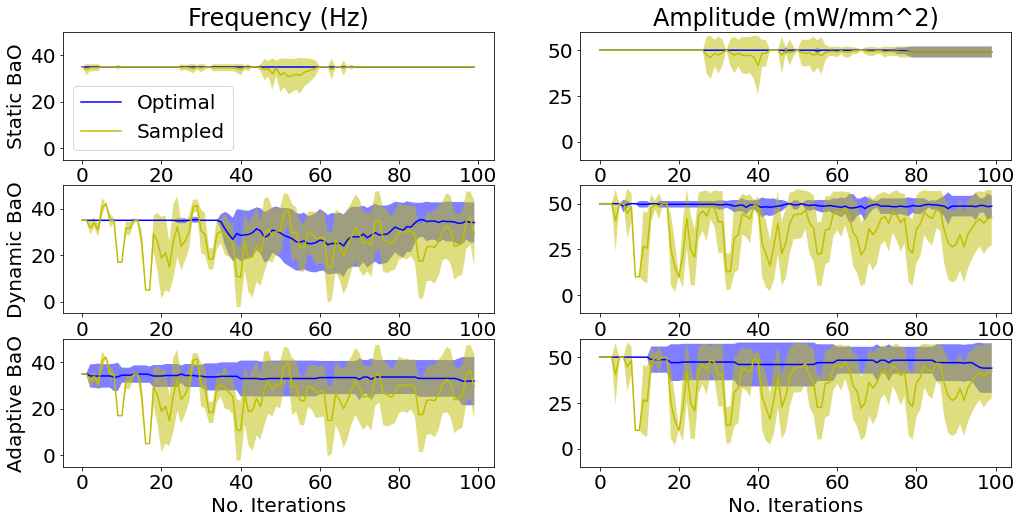

In [95]:
plt.rc('font', size=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
# fig.suptitle("Simulation vs. Static/Dynamic BaO", fontsize=16)
plt.subplot(3,2,1)
plt.plot(x_acquisitions, static_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,0]+static_sample_std[:,0],
                static_sample_mean[:,0]-static_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,0]+static_ucb_std[:,0],
                static_ucb_mean[:,0]-static_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
# plt.xlabel("No. Iterations")
plt.ylabel("Static BaO")
plt.title("Frequency (Hz)")
plt.legend(["Optimal", "_Hidden", "Sampled", "_Hidden"]);
# plt.grid(visible=True)

plt.subplot(3,2,2)
plt.plot(x_acquisitions, static_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,1]+static_sample_std[:,1],
                static_sample_mean[:,1]-static_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,1]+static_ucb_std[:,1],
                static_ucb_mean[:,1]-static_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
# plt.xlabel("No. Iterations")
plt.title("Amplitude (mW/mm^2)")
# plt.legend(["Simulation", '_Hidden', "Static", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,3)
plt.plot(x_acquisitions, dynamic_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,0]+dynamic_sample_std[:,0],
                dynamic_sample_mean[:,0]-dynamic_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,0]+dynamic_ucb_std[:,0],
                dynamic_ucb_mean[:,0]-dynamic_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
# plt.xlabel("No. Iterations")
plt.ylabel("Dynamic BaO")
# plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,4)
plt.plot(x_acquisitions, dynamic_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,1]+dynamic_sample_std[:,1],
                dynamic_sample_mean[:,1]-dynamic_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,1]+dynamic_ucb_std[:,1],
                dynamic_ucb_mean[:,1]-dynamic_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
# plt.xlabel("acquisition")
# plt.ylabel("amplitude")
# plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,5)
plt.plot(x_acquisitions, adaptive_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, adaptive_sample_mean[:,0]+adaptive_sample_std[:,0],
                adaptive_sample_mean[:,0]-adaptive_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_ucb_mean[:,0]+adaptive_ucb_std[:,0],
                adaptive_ucb_mean[:,0]-adaptive_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
plt.xlabel("No. Iterations")
plt.ylabel("Adaptive BaO")
# plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,6)
plt.plot(x_acquisitions, adaptive_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, adaptive_sample_mean[:,1]+adaptive_sample_std[:,1],
                adaptive_sample_mean[:,1]-adaptive_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, adaptive_ucb_mean[:,1]+adaptive_ucb_std[:,1],
                adaptive_ucb_mean[:,1]-adaptive_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
plt.xlabel("No. Iterations")
# plt.ylabel("amplitude")
# plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)
plt.show();


In [96]:
static_lengthscale_mean.shape

(2, 100)

 C:\Users\sinad\AppData\Local\Temp\ipykernel_28528\3750503751.py:17: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000001E6AEC494C0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_28528\3750503751.py:17: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000001E6AEC49B80> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_28528\3750503751.py:30: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000001E6AEC8BAC0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_28528\3750503751.py:30: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000001E6AEC7E7F0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_28528\3

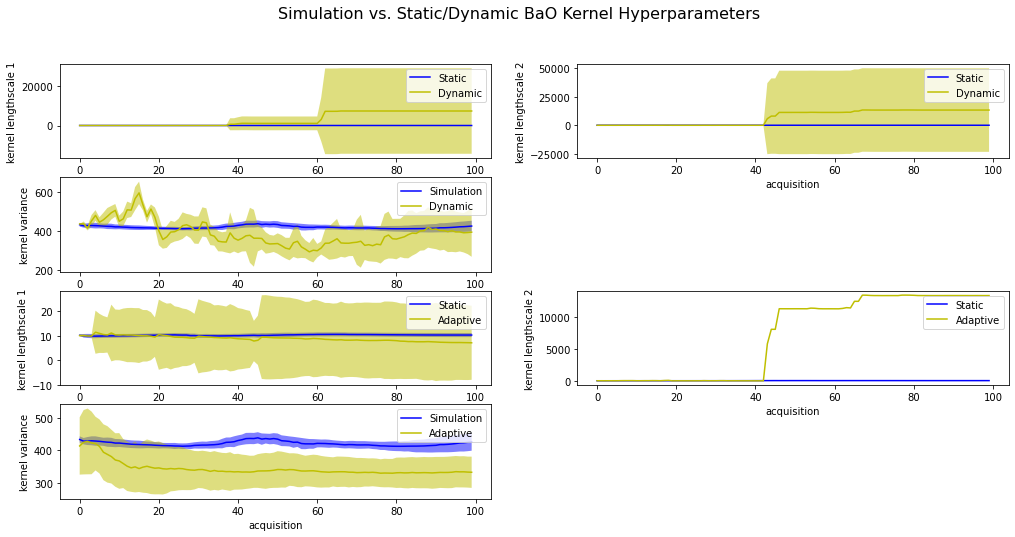

In [110]:
plt.rc('font', size=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.suptitle("Simulation vs. Static/Dynamic BaO Kernel Hyperparameters", fontsize=16)
plt.subplot(4,2,1)
plt.plot(x_acquisitions, static_lengthscale_mean[0,:], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[0,:]+static_lengthscale_std[0,:],
                static_lengthscale_mean[0,:]-static_lengthscale_std[0,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[0,:], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_lengthscale_mean[0,:]+dynamic_lengthscale_std[0,:],
                dynamic_lengthscale_mean[0,:]-dynamic_lengthscale_std[0,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
# plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 1")
plt.legend(["Static", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(4,2,2)
plt.plot(x_acquisitions, static_lengthscale_mean[1,:], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[1,:]+static_lengthscale_std[1,:],
                static_lengthscale_mean[1,:]-static_lengthscale_std[1,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[1,:], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_lengthscale_mean[1,:]+dynamic_lengthscale_std[1,:],
                dynamic_lengthscale_mean[1,:]-dynamic_lengthscale_std[1,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 2")
plt.legend(["Static", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(4,2,3)
plt.plot(x_acquisitions, static_variance_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_variance_mean[:,0]+static_variance_std[:,0],
                static_variance_mean[:,0]-static_variance_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_variance_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_variance_mean[:,0]+dynamic_variance_std[:,0],
                dynamic_variance_mean[:,0]-dynamic_variance_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
# plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(4,2,5)
plt.plot(x_acquisitions, static_lengthscale_mean[0,:], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[0,:]+static_lengthscale_std[0,:],
                static_lengthscale_mean[0,:]-static_lengthscale_std[0,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_lengthscale_mean[0,:], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[0,:]+adaptive_lengthscale_std[0,:],
                adaptive_lengthscale_mean[0,:]-adaptive_lengthscale_std[0,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
# plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 1")
plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(4,2,6)
plt.plot(x_acquisitions, static_lengthscale_mean[1,:], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[1,:]+static_lengthscale_std[1,:],
                static_lengthscale_mean[1,:]-static_lengthscale_std[1,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[1,:], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[1,:]+adaptive_lengthscale_std[1,:],
                adaptive_lengthscale_mean[1,:]-adaptive_lengthscale_std[1,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 2")
plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)

# plt.subplot(4,2,7)
# plt.plot(x_acquisitions, static_lengthscale_mean[2,:], label=r"time", color='b')
# plt.fill_between(x_acquisitions, static_lengthscale_mean[2,:]+static_lengthscale_std[2,:],
#                 static_lengthscale_mean[2,:]-static_lengthscale_std[2,:], alpha=0.5, facecolor='b', label='_Hidden')
# plt.plot(x_acquisitions, dynamic_lengthscale_mean[2,:], label=r"time", color='y')
# plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[2,:]+adaptive_lengthscale_std[2,:],
#                 adaptive_lengthscale_mean[2,:]-adaptive_lengthscale_std[2,:], alpha=0.5, facecolor='y', label='_Hidden')
# # plt.ylim([-5, 50])
# plt.xlabel("acquisition")
# plt.ylabel("kernel lengthscale 3")
# plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(4,2,7)
plt.plot(x_acquisitions, static_variance_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_variance_mean[:,0]+static_variance_std[:,0],
                static_variance_mean[:,0]-static_variance_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_variance_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_variance_mean[:,0]+adaptive_variance_std[:,0],
                adaptive_variance_mean[:,0]-adaptive_variance_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)

plt.show();

#### 1.7.3 Number of samples to converge

In [98]:
derivative_static_freq = np.gradient(static_ucb_mean[:,0])
idx_derivative_satic_freq = np.where(derivative_static_freq==0)
print("The derivative of Static Freq is: ", derivative_static_freq, "\n index where static freq plateaus: ", idx_derivative_satic_freq)

derivative_static_amp = np.gradient(static_ucb_mean[:,1])
idx_derivative_satic_amp = np.where(derivative_static_amp==0)
print("The derivative of Static Amp is: ", derivative_static_amp, "\n index where static freq plateaus: ", idx_derivative_satic_amp)

idx_plateau_static_freq = []
idx_plateau_static_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_static_freq[p:p+1]==0. :
        idx_plateau_static_freq = np.append(idx_plateau_static_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_static_amp[p:p+1]==0. :
        idx_plateau_static_amp = np.append(idx_plateau_static_amp,[p+1])
        
print("The idx of first plateau for static model with length 2 sample for freq is: ", idx_plateau_static_freq[0]) 
print("The idx of first plateau static model with length 2 sample for amp is: ", idx_plateau_static_amp[0]) 

The derivative of Static Freq is:  [-1.2 -0.2  0.4  0.   0.2  0.2  0.   0.  -0.1  0.   0.1  0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.2 -0.1  0.  -0.3
  0.1  0.1  0.   0.3 -0.1 -0.2  0.   0.   0.   0.  -0.1 -0.4  0.2  0.4
  0.1  0.2 -0.2 -0.6 -0.2 -0.9  0.1 -0.3 -1.  -0.3 -0.6  0.5  0.   0.4
  1.   0.6  0.6  0.6  0.3  0.  -0.6  0.   0.6 -0.3  0.   0.2  0.   0.1
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0. ] 
 index where static freq plateaus:  (array([ 3,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       26, 30, 34, 35, 36, 37, 54, 61, 63, 66, 68, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
       93, 94, 95, 96, 97, 98, 99], dtype=int64),)
The derivative of Static Amp is:  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.      

In [99]:
derivative_dynamic_freq = np.gradient(dynamic_ucb_mean[:,0])
idx_derivative_dynamic_freq = np.where(derivative_dynamic_freq==0)
print("The derivative of dynamic Freq is: ", derivative_dynamic_freq, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_freq)

derivative_dynamic_amp = np.gradient(dynamic_ucb_mean[:,1])
idx_derivative_dynamic_amp = np.where(derivative_dynamic_amp==0)
print("The derivative of dynamic Amp is: ", derivative_dynamic_amp, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_amp)

idx_plateau_dynamic_freq = []
idx_plateau_dynamic_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_dynamic_freq[p:p+1]==0. :
        idx_plateau_dynamic_freq = np.append(idx_plateau_dynamic_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_dynamic_amp[p:p+1]==0. :
        idx_plateau_dynamic_amp = np.append(idx_plateau_dynamic_amp,[p+1])
        
print("The idx of first plateau for dynamic model with length 2 sample for freq is: ", idx_plateau_dynamic_freq[0]) 
print("The idx of first plateau dynamic model with length 2 sample for amp is: ", idx_plateau_dynamic_amp[0]) 

The derivative of dynamic Freq is:  [  0.          -1.6         -0.5         -0.5          3.35
   5.6         -2.9         -3.6         -8.95        -8.9
   7.3          7.2          1.6          1.8         -4.4
 -15.         -10.5         12.1         10.36666667  -5.18333333
  -2.38333333  -2.01666667   2.56666667   8.71666667  -1.11666667
  -3.01666667   3.06666667   7.33333333   5.66666667  -5.26666667
  -6.15        -5.96666667  -5.31666667   5.4          5.9
  -0.1         -1.6         -1.8         -8.03333333  -7.43333333
   7.5          4.11666667  -3.31666667   2.81666667   0.75
   2.15         5.3         -0.23333333  -0.48333333   1.11666667
   3.75         4.58333333  -4.2         -4.98333333  -2.95
  -3.23333333   3.           3.          -1.21666667  -0.98333333
   0.31666667  -6.21666667  -6.4          5.81666667   4.3
  -3.2         -0.01666667   3.98333333   4.1          0.45
  -3.46666667  -1.65        -0.2          4.31666667   5.31666667
  -3.76666667  -4.6       

In [100]:
idx_static_vs_dynamic_freq = idx_plateau_dynamic_freq[0] - idx_plateau_static_freq[0]
idx_static_vs_dynamic_amp = idx_plateau_dynamic_amp[0] - idx_plateau_static_amp[0]

print("the dynamic freq plateaus at sample %d after the static sample.", idx_static_vs_dynamic_freq)
print("the dynamic amp plateaus at sample %d after the static sample.", idx_static_vs_dynamic_amp)

the dynamic freq plateaus at sample %d after the static sample. -3.0
the dynamic amp plateaus at sample %d after the static sample. 0.0


In [101]:
print(np.shape(idx_plateau_static_freq),
     np.shape(idx_plateau_static_amp),
     np.shape(idx_plateau_dynamic_freq),
     np.shape(idx_plateau_dynamic_amp))

(58,) (57,) (1,) (7,)


<AxesSubplot:>

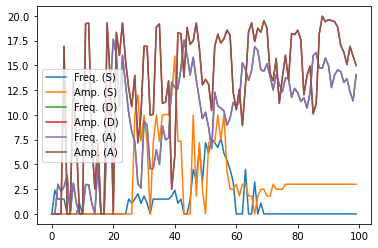

In [111]:
# number of samples to converge:
std_dev_ucb_df.plot.line()

In [103]:
std_dev_ucb_df.describe()

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.236187,3.307565,10.138554,13.340971,10.138554,13.340971
std,2.066823,3.585263,5.091237,6.081530,5.091237,6.081530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.106396,10.753994,7.106396,10.753994
50%,0.000000,3.000000,11.643065,15.029535,11.643065,15.029535
75%,1.496663,3.000000,14.039695,18.201800,14.039695,18.201800
max,7.665507,15.933891,17.639129,19.955506,17.639129,19.955506


In [104]:
std_dev_static_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Freq. (S)']<std_dev_ucb_df['Freq. (S)'].mean(),['Freq. (S)']].index
std_dev_static_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Amp. (S)']<std_dev_ucb_df['Amp. (S)'].mean(),['Amp. (S)']].index

std_dev_dynamic_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Freq. (D)']<std_dev_ucb_df['Freq. (D)'].mean(),['Freq. (D)']].index
std_dev_dynamic_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Amp. (D)']<std_dev_ucb_df['Amp. (D)'].mean(),['Amp. (D)']].index
print('std_dev_static_freq_converge \n', std_dev_static_freq_converge)
print('std_dev_static_amp_converge \n', std_dev_static_amp_converge)
print('std_dev_dynamic_freq_converge \n', std_dev_dynamic_freq_converge)
print('std_dev_dynamic_amp_converge \n', std_dev_dynamic_amp_converge)

std_dev_static_freq_converge 
 Int64Index([ 0,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
            21, 22, 23, 24, 26, 29, 31, 32, 41, 43, 44, 60, 61, 62, 64, 65, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')
std_dev_static_amp_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 43, 44, 45, 47, 49, 50,
            58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
            75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
            92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')
std_dev_dynamic_freq_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 49, 51,
            52, 5

In [105]:
print(np.shape(std_dev_static_freq_converge),
     np.shape(std_dev_static_amp_converge),
     np.shape(std_dev_dynamic_freq_converge),
     np.shape(std_dev_dynamic_amp_converge))

(66,) (76,) (37,) (37,)


#### 1.7.4: Comparing the Simulation with Static/Dynamic models using Normalized Mean-Squared-Error (NMSE).

$$NMSE(GP_{est}, GP_{sim})= \frac{||\mu_{est}(x)-\mu_{sim}(s)||_2^2}{||\mu_{sim}(x)||_2^2} $$

In [106]:
nmse_static_simulatinon_freq = np.square(np.subtract(static_ucb_mean[:,0], static_sample_mean[:, 0])).mean()/(np.square(static_sample_mean[:, 0])).mean()
nmse_static_simulatinon_freq = np.round(nmse_static_simulatinon_freq, 4)
print("nmse_static_simulatinon_freq: ", nmse_static_simulatinon_freq)
nmse_static_simulatinon_amp = np.square(np.subtract(static_ucb_mean[:,1], static_sample_mean[:, 1])).mean()/(np.square(static_sample_mean[:, 1])).mean()
nmse_static_simulatinon_amp = np.round(nmse_static_simulatinon_amp, 4)
print("nmse_static_simulatinon_amp: ", nmse_static_simulatinon_amp, '\n')

nmse_dynamic_simulatinon_freq = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 0])).mean()/(np.square(dynamic_sample_mean[:, 0])).mean()
nmse_dynamic_simulatinon_freq = np.round(nmse_dynamic_simulatinon_freq, 4)
print("nmse_dynamic_simulatinon_freq: ", nmse_dynamic_simulatinon_freq)
nmse_dynamic_simulatinon_amp = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 1])).mean()/(np.square(dynamic_sample_mean[:, 1])).mean()
nmse_dynamic_simulatinon_amp = np.round(nmse_dynamic_simulatinon_amp, 4)
print("nmse_dynamic_simulatinon_amp: ", nmse_dynamic_simulatinon_amp)

nmse_static_simulatinon_freq:  0.0009
nmse_static_simulatinon_amp:  0.0008 

nmse_dynamic_simulatinon_freq:  0.0776
nmse_dynamic_simulatinon_amp:  0.2221


In [107]:
print(np.shape(static_ucb_std))

(100, 3)


In [108]:
# Post stimulation Gamma comparison plots

postStim_gamma_df = pd.DataFrame({"Sim. S": simulation_postStimGamma_predicted.flatten('C'),
                                 "Static": static_postStimGamma_predicted.flatten('C'),
                                 "Sim. D": simulation_postStimGamma_predicted_d.flatten('C'),
                                 "Dynamic": dynamic_postStimGamma_predicted.flatten('C'),
                                 "Sim. A": simulation_postStimGamma_predicted_a.flatten('C'),
                                 "Adaptive": adaptive_postStimGamma_predicted.flatten('C')})
postStim_gamma_df.head()

,Sim. S,Static,Sim. D,Dynamic,Sim. A,Adaptive
0,46.413894,45.332529,44.926320,44.145211,15.049708,-4.156419
1,50.681808,41.321480,44.362530,48.288684,1.513990,1.731468
2,48.842648,47.581183,45.819219,48.163610,16.644860,-11.494282
3,45.194046,48.653652,42.560661,42.320041,-7.249745,12.256860
4,47.376566,48.277090,45.376085,48.521257,-0.201847,-40.161998


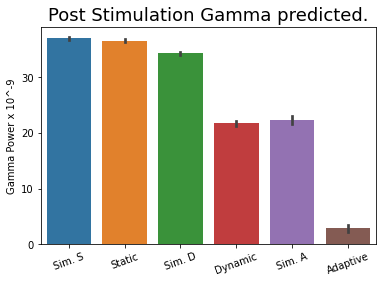

In [112]:
sns.barplot(data=postStim_gamma_df);
plt.rc('font', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.ylabel("Gamma Power x 10^-9");
plt.title("Post Stimulation Gamma predicted.");
plt.xticks(rotation=20)
plt.show();

#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end

## 4. Closed Loop BaO